# Part 1: Generate the first tree

In [204]:
#Theses functions load the data

def read_data():
    data_text = ""
    with open("skysurvey/training_data.csv","r") as f:
        data_text = f.read()
    
    data_text = data_text.split("\n")
    
    data = []
    for ligne in data_text:
        data.append(ligne.split(","))

    
    #il y a un retour à la ligne à la fin du fichier de donnés, donc une ligne vide....
    del(data[-1])

    return data

def read_class():
    cls_text = ""
    with open("skysurvey/training_class.csv","r") as f:
        cls_text = f.read()
    cls = cls_text.split("\n")
    del(cls[-1])
    return cls


def get_feature_names():
    feature_names = ""
    with open("skysurvey/Skyserver.csv","r") as f:
        feature_names = f.readline().strip()
    feature_names = feature_names.split(",")
    feature_names.remove("objid")
    feature_names.remove("class")
    return feature_names

def read_testing_set():
    data_text = ""
    with open("skysurvey/Skyserver.csv","r") as f:
        data_text = f.read()
    
    data_text = data_text.split("\n")
    
    data = []
    for ligne in data_text:
        data.append(ligne.split(","))

    
    #il y a un retour à la ligne à la fin du fichier de donnés, donc une ligne vide....
    del(data[-1])

    return data

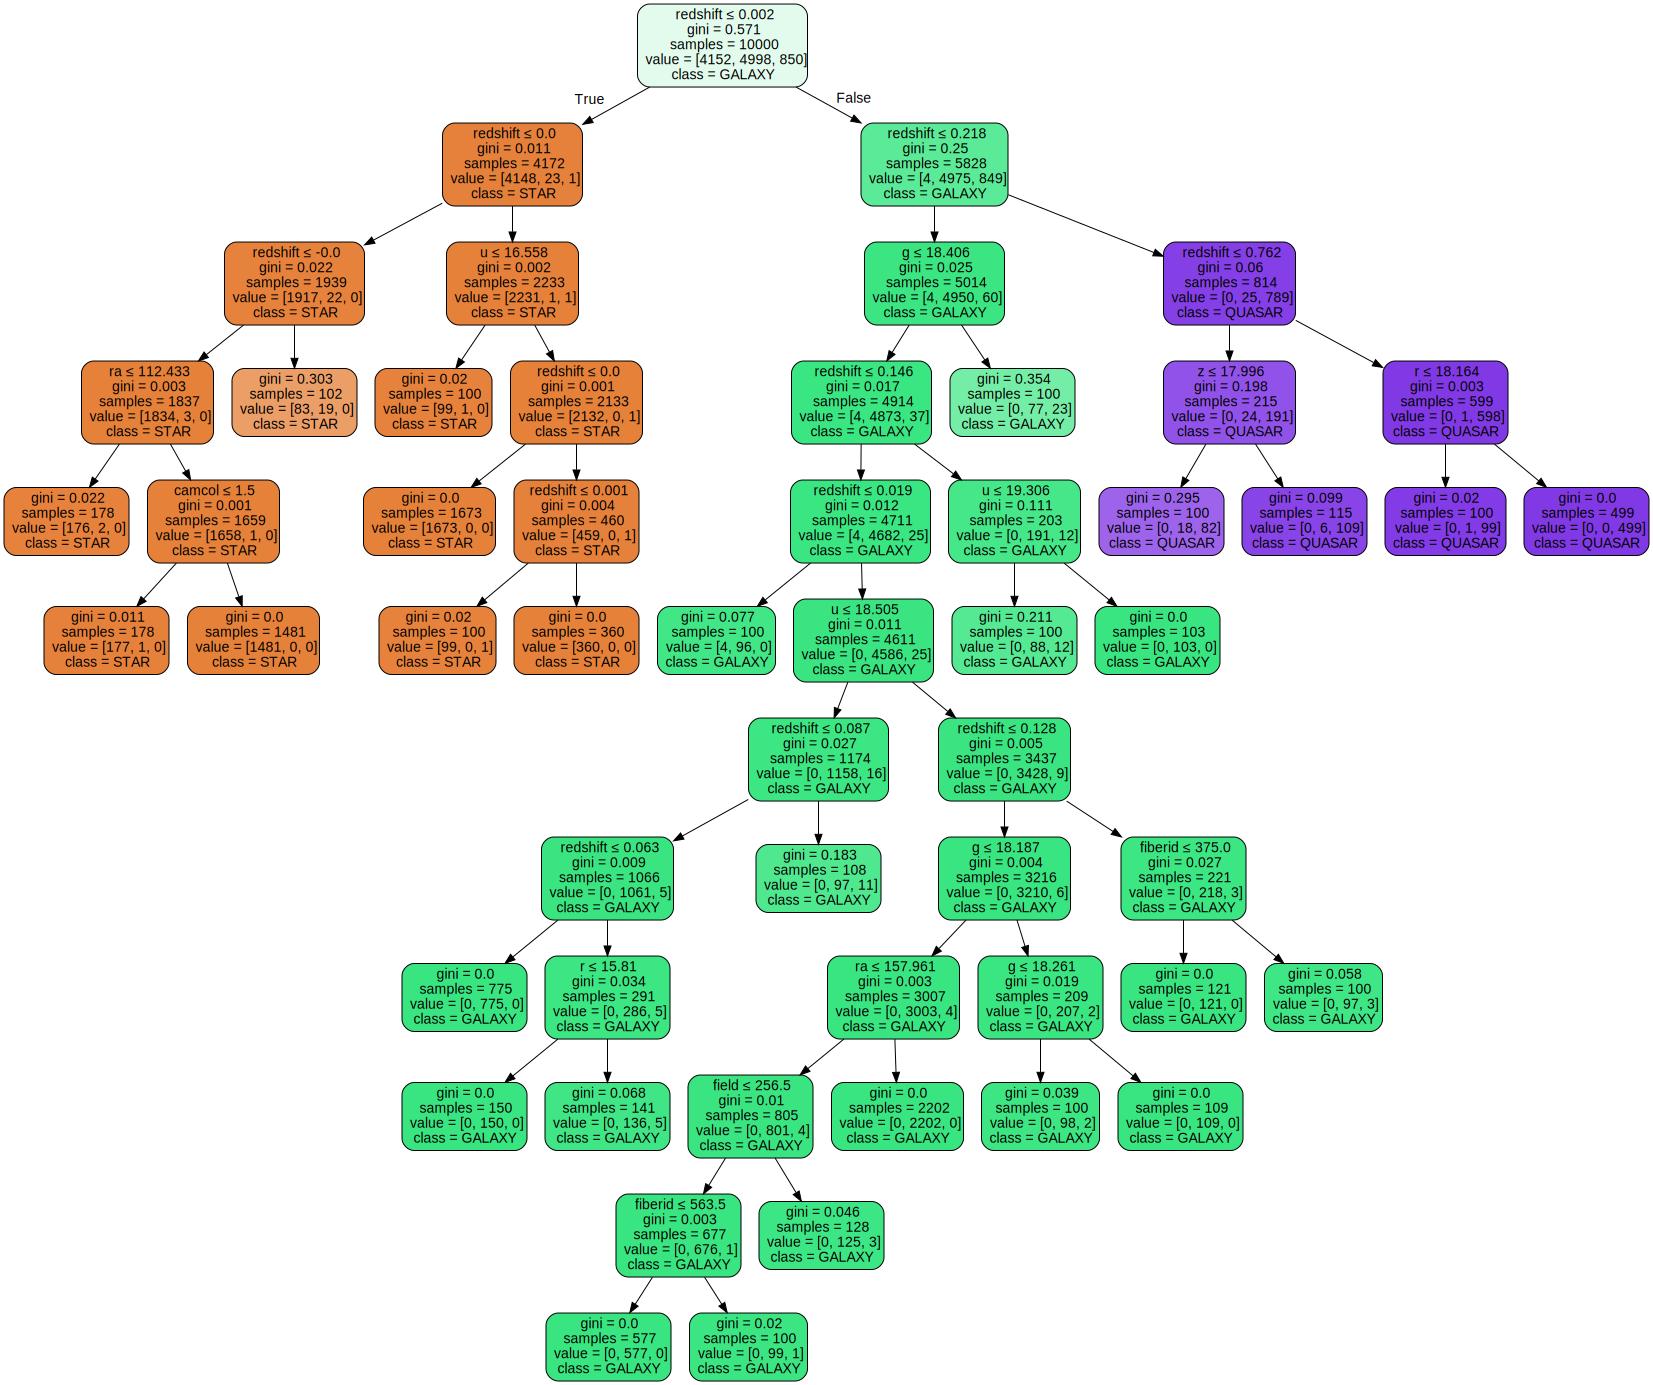

In [205]:
import numpy as np
from sklearn import tree
from sklearn.externals.six import StringIO
import pydot
import graphviz

clf = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 0.01)#, max_depth = 2, min_impurity_decrease = 0.01)
clf = clf.fit(read_data(), read_class())

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=get_feature_names(),  
                         class_names=["STAR","GALAXY","QUASAR"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graphv = graphviz.Source(dot_data)
graphv

In [206]:
from sklearn.externals.six import StringIO
import pydot

dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data, 
                         feature_names=get_feature_names(),  
                         class_names=["STAR","GALAXY","QSO"],  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph[0].write_pdf("tree.pdf")

In [207]:
def training_error(clf):
    return 1-clf.score(read_data(),read_class())



print("training errors:"+str((training_error(clf))))

training errors:0.011299999999999977


In [208]:
def nb_leaves(clf):
    NbLeaves = 0
    for elt in clf.tree_.children_left:
        NbLeaves += (elt == -1)
    return NbLeaves

def gen_error(clf):
    return training_error(clf)+0.5*float(nb_leaves(clf))/10000

print("NbLeaves :"+str(nb_leaves(clf)))
print("gen error:"+str(gen_error(clf)))

NbLeaves :28
gen error:0.012699999999999977


# Part 2: Generate the optimized tree

In [209]:
#QUESTION 3 Met quelques minutes a s'executer !

def compute_param():
    criterions = ["gini","entropy"]
    depths = list(range(1,26)) #no point of taking deepper trees (easy to check)
    impurities = [0.01 * k for k in range(0,20)] #I did some pre-trials to guess good possible values for min_impurity_decrease
    
    best_error = 1
    best_criterion = "gini"
    best_depth = 1
    best_impurity = 0
    
    data = read_data()
    cls = read_class()
    
    for criterion in criterions:
        for depth in depths:
            for impurity in impurities:
                clf = tree.DecisionTreeClassifier(criterion = criterion, min_samples_leaf = 0.01, max_depth=depth, min_impurity_decrease = impurity)
                clf = clf.fit(data, cls)
                error = gen_error(clf)
                if best_error>error:
                    best_error = error
                    best_criterion = criterion
                    best_depth = depth
                    best_impurity = impurity
    
    return (best_error, best_criterion, best_depth, best_impurity)


print compute_param()

(0.011449999999999978, 'gini', 2, 0.01)


0.011449999999999978


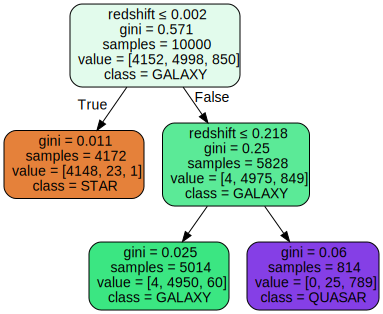

In [217]:
clf = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 0.01, max_depth = 2, min_impurity_decrease = 0.01)
clf = clf.fit(read_data(), read_class())

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=get_feature_names(),  
                         class_names=["STAR","GALAXY","QUASAR"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graphv = graphviz.Source(dot_data)


print gen_error(clf)
graphv

# Part 3: Post-Pruning

0.012699999999999977


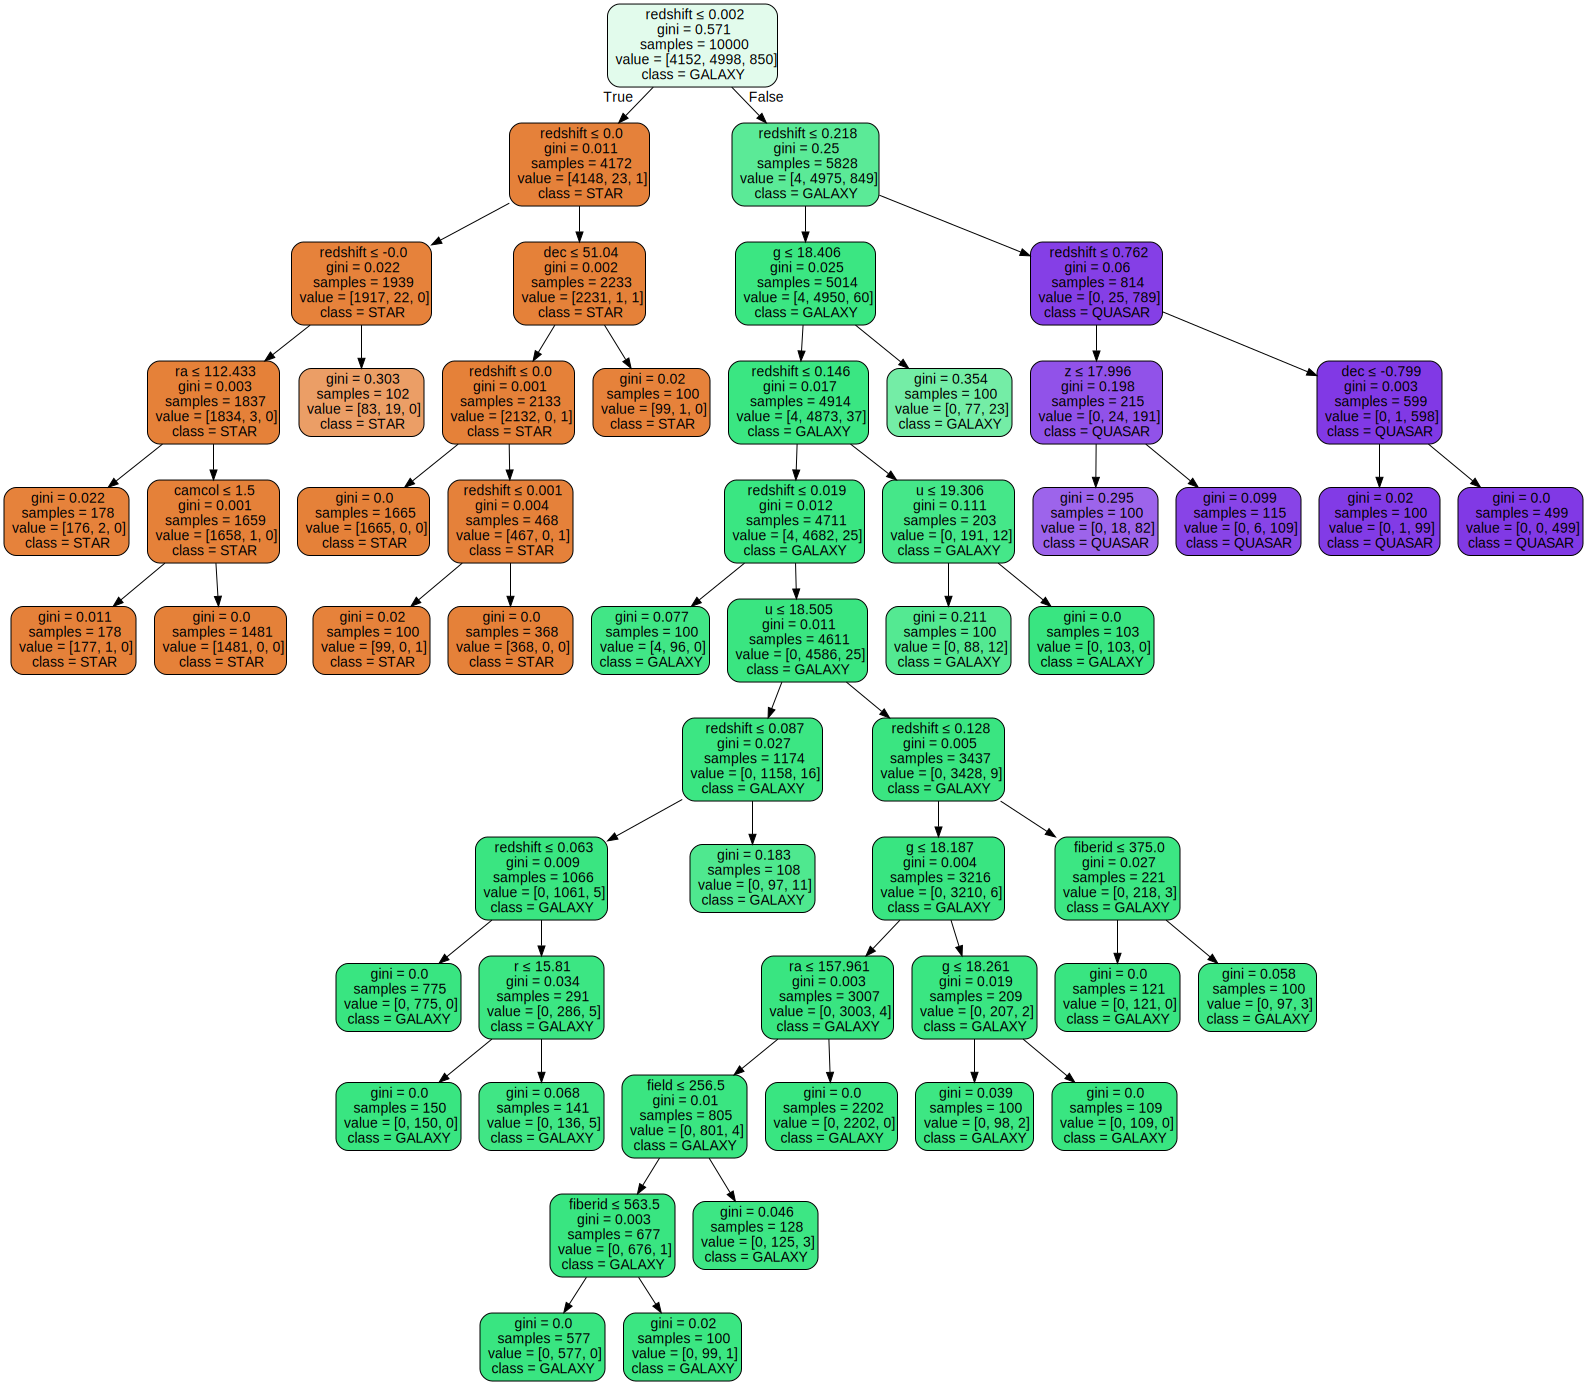

In [218]:
clf = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 0.01)
clf = clf.fit(read_data(), read_class())

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=get_feature_names(),  
                         class_names=["STAR","GALAXY","QUASAR"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graphv = graphviz.Source(dot_data)


print(gen_error(clf))
graphv

In [215]:
#These functions are used to prune clf (directly modify it)

#Return the indice of the maximum in L
def indice_max(L):
    ind = 0
    m = L[0]
    for i in range(len(L)):
        if L[i]>m:
            ind = i
            m = L[i]
    return ind


#Deleted the sons of node i
def delete(d, i):
    nodes = d["nodes"]
    values = d["values"]
    i_left = nodes[i][0]
    i_right = nodes[i][1]
    
    del(nodes[i_right])
    del(nodes[i_left])
    del(values[i_right])
    del(values[i_left])
    d["node_count"] -= 2
    
    # what about depth ? Should probably compute it at the end of the pruning ?
    
    nodes[i][0] = -1
    nodes[i][1] = -1
    nodes[i][2] = -2
    nodes[i][3] = -2
    
    for k in range(d["node_count"]):
        nodes[k][0] -= 2*(nodes[k][0]>i)
        nodes[k][1] -= 2*(nodes[k][1]>i)

    
    


#Post prune the tree recursively 
#Return 1 if node_i is now a leaf, 0 otherwise
def _post_prune(d, i = 0):
    nodes = d["nodes"]
    values = d["values"]
    
    #it's a leaf !
    if (nodes[i][0] == -1):
        return 1;
    
    #it's a node !
    leaf_left = _post_prune(d, nodes[i][0])
    leaf_right = _post_prune(d, nodes[i][1])
    
    #Can only prune if both our sons are leaves
    if not (leaf_left and leaf_right):
        return 0;
    
    #Let's compute if it's worth it.
    #As it is a binary tree, prune one node will only improved the generalization error
    #by 1/2 - (increase of training errors). 
    #Thus we only prune if they don't change the training error
    #which imply that we only prune if the leafs decide the same class !  
    
    i_left = nodes[i][0]
    i_right = nodes[i][1]
    
    #Test if they decide the same class
    if indice_max(values[i_right][0]) != indice_max(values[i_left][0]):
        #Not worth pruning
        return 0
    
    #lets prune -> only have to delete the leaves from the tree.
    
    delete(d, i)
    
    #it's a leaf now
    return 1


# postprune clf
# Uses clf._tree and Tree.__getstate__/Tree._setstate__ to modify directly clf !
def post_prune(clf):
    d = clf.tree_.__getstate__()
    d["nodes"] = list(d["nodes"])
    for i in range(len(d["nodes"])):
        d["nodes"][i]=list(d["nodes"][i])
    d["values"] = list(d["values"])
    
    _post_prune(d)
    
    for i in range(len(d["nodes"])):
        d["nodes"][i]=tuple(d["nodes"][i])
    d["nodes"] = np.array(d["nodes"], dtype=[('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')])
    d["values"] = np.array(d["values"])
    
    clf.tree_.__setstate__(d)

0.011449999999999978


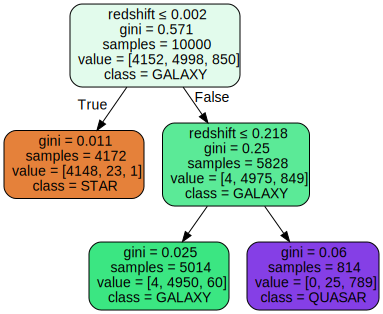

In [216]:
post_prune(clf)

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=get_feature_names(),  
                         class_names=["STAR","GALAXY","QUASAR"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graphv = graphviz.Source(dot_data)


print(gen_error(clf))
graphv
